# P4W3: Neurale Netwerken

In [46]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
import math
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
#from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
from livelossplot import PlotLossesKeras

## 0. Guidelines
1. Activatie functie hidden layers: **relu** of **sigmoid** zijn populair
2. Activatie functie output layer:
     - classificatie met one-hot encoding: **softmax** (geeft kansen voor elke output met som 1)
     - classificatie met 2 klassen en 1 output: **sigmoid** (geeft 1 kans) **PS:** kan voor 2 klassen ook one-hot encoding gebruiken (dan heb je 2 outputs)
     - regressie: **linear**
3. Backpropagation algoritme: **Adam** is populair (learning_rate geeft aan hoeveel de gewichten/biases aangepast worden)
4. Loss functie:
     - classificatie met one-hot encoding: **categorical_crossentropy** (is een soort afstand tussen kansen)
     - classificatie met 2 klassen en 1 output: **binary_crossentropy** 
     - regressie: **MeanSquaredError** of **MeanAbsoluteError**
5. Metrics kunnen optioneel toegevoegd worden

|                                | output activation | loss                     |   metrics     |
|:-------------------------------|:------------------|:-------------------------|:--------------|
| regressie                      |   linear          | MeanSquaredError()       |  MeanAbsolutePercentageError()   |
|                                |                   | MeanAbsoluteError()      |              |
| classificatie 1 output         |   sigmoid         |    binary_crossentropy   |  accuracy    |
| classificatie one-hot encoding |   softmax        | categorical_crossentropy |  accuracy    |

6. Epochs: hoeveel keer je over de volledige training dataset loopt
7. batch_size: grootte van batch (default is 32) waarna backpropagation (aanpassing van de gewichten/biases) gebeurt. Als bv. de training dataset 1000 samples bevat en de batch_size is 100, dan zullen er 10 backpropagations zijn per epoch.

## 1. XOR

In [47]:
# Step 1: Upload the dataset and inspect the data
xor_data = pd.DataFrame({'P1': [0,1,0,1], 'P2': [0,0,1,1], 'Q' : [0,1,1,0]})
x_xor_data = xor_data[['P1', 'P2']]
y_xor_data = xor_data[['Q']]

In [48]:
# Step 5: Build the ANN-model

inputs_xor = Input(shape=(2,))
x_xor = Dense(2, activation='sigmoid')(inputs_xor)  
outputs_xor = Dense(1, activation='sigmoid')(x_xor)
model_xor = Model(inputs_xor, outputs_xor, name='XOR_NN')

model_xor.summary()
plot_model(model_xor, to_file='model_xor_plot.png', show_shapes=True, show_layer_names=True)

model_xor.compile(optimizer=Adam(learning_rate=0.001),
                  loss=keras.losses.binary_crossentropy,
                  metrics=['accuracy'])

Model: "XOR_NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


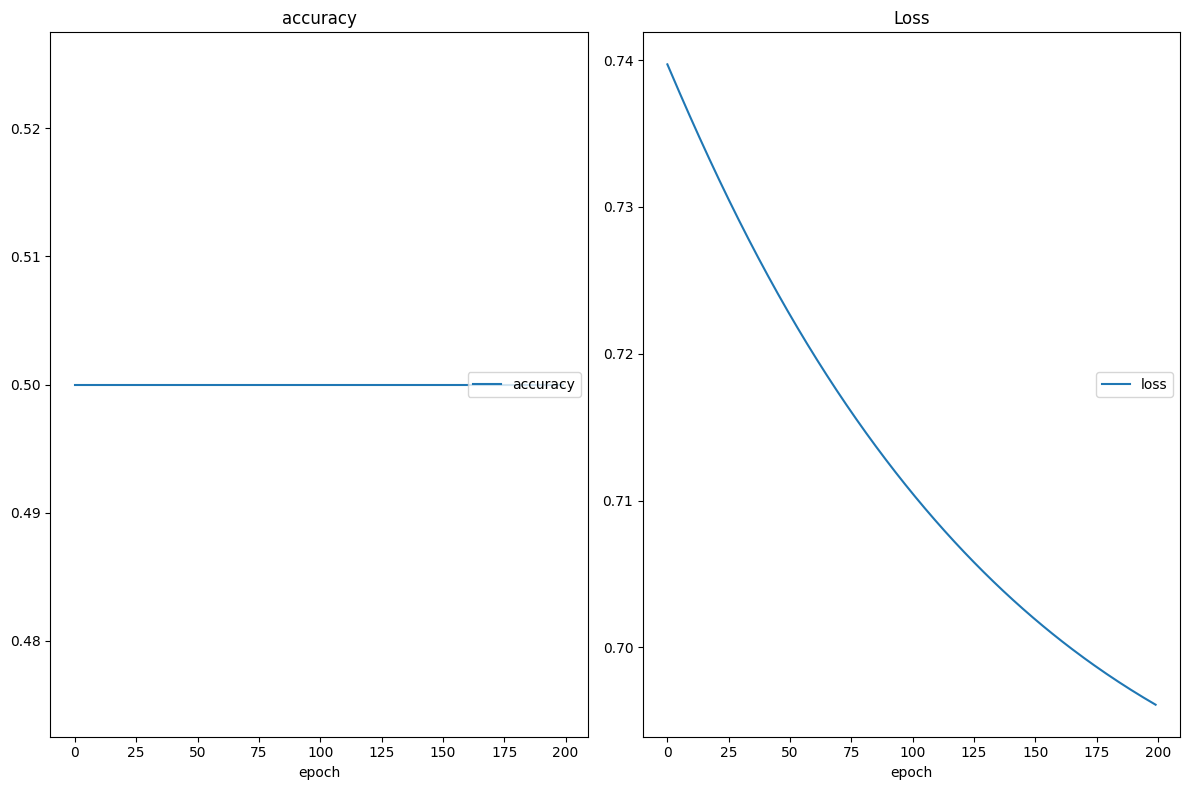

accuracy
	accuracy         	 (min:    0.500, max:    0.500, cur:    0.500)
Loss
	loss             	 (min:    0.696, max:    0.740, cur:    0.696)


In [49]:
# Step 6: Train the ANN-model
history_xor = model_xor.fit(x_xor_data, 
                            y_xor_data, epochs=200, 
                            callbacks=[PlotLossesKeras()], 
                            verbose=False
                           )

In [50]:
# Ter info: de gewichten en biases
for lay in model_xor.layers:
    print(lay.name)
    print(lay.get_weights())

input_layer_8
[]
dense_25
[array([[ 0.33289793,  1.168562  ],
       [-0.65800726,  1.2564929 ]], dtype=float32), array([-0.15321872, -0.13838938], dtype=float32)]
dense_26
[array([[0.2989063 ],
       [0.43096063]], dtype=float32), array([-0.1671503], dtype=float32)]


In [51]:
# Step 7: Evaluate the quality of the ANN-model
model_xor.predict(x_xor_data) # should be [0,1,1,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[0.54276276],
       [0.57768804],
       [0.5620755 ],
       [0.5838108 ]], dtype=float32)

In [52]:
model_xor.evaluate(x_xor_data, y_xor_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5000 - loss: 0.6960


[0.6960020661354065, 0.5]

## 2. MNIST

In [53]:
# Stap 1 & 4: Laad de dataset op splits de dataset op in een training- en test dataset
import keras.datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Stap 2: Data management manipulaties
### 60000 training images met 28x28 pixels en hun geassocieerd nummer
print(x_train.shape)
print(y_train.shape)
### Transformeer de 2D-images in 1D-vectoren
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))
print(x_train.shape)
### Targetwaarden getransformeerd in One-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)

(60000, 28, 28)
(60000,)
(60000, 784)
(60000, 10)


In [54]:
# Stap 5: construeer het ANN-model

inputs = Input(shape=(784,))
x = BatchNormalization()(inputs)      # dit is een ander soort laag
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs, name='MNIST_Crusher')

model.summary()
plot_model(model, to_file='model_MNIST_plot.png', show_shapes=True, show_layer_names=True)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

Model: "MNIST_Crusher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,186 (227.29 KB)

 Trainable params: 56,618 (221.16 KB)

 Non-trainable params: 1,568 (6.12 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


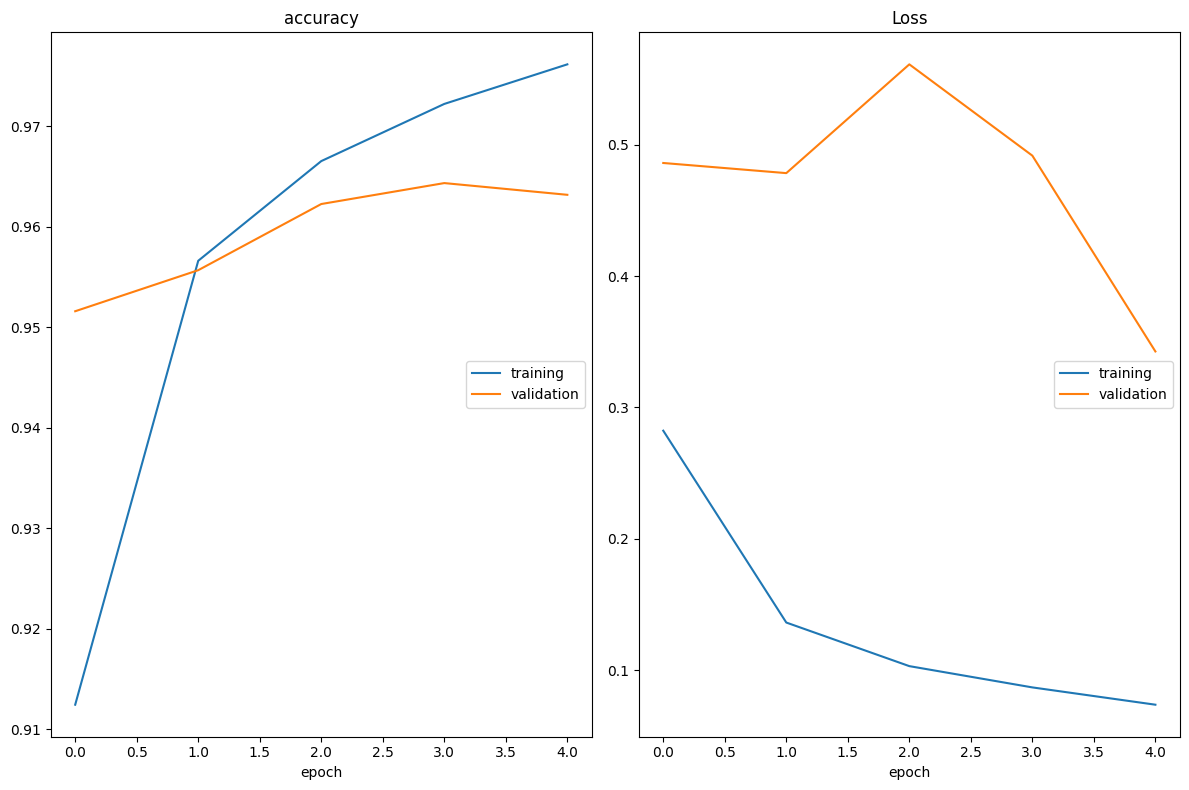

accuracy
	training         	 (min:    0.912, max:    0.976, cur:    0.976)
	validation       	 (min:    0.952, max:    0.964, cur:    0.963)
Loss
	training         	 (min:    0.074, max:    0.282, cur:    0.074)
	validation       	 (min:    0.343, max:    0.561, cur:    0.343)
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9770 - loss: 0.0700 - val_accuracy: 0.9632 - val_loss: 0.3426


In [55]:
# Stap 6: Train het ANN-model
history = model.fit(
    x_train, # training data
    y_train, # training targets
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[PlotLossesKeras()]
)

In [56]:
# Stap 7: Evalueer de kwaliteit van het ANN-model
model.evaluate(x_test,y_test)
# Voorspel de eerste 5 images uit de test dataset
print(model.predict(x_test[:5]))
print(np.argmax(model.predict(x_test[:5]),axis=1)) # [7 2 1 0 4]
# vergelijk met het werkelijke nummer
print(np.argmax(y_test[:5], axis=1)) # [7 2 1 0 4]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.9641 - loss: 0.3168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[4.47644560e-10 1.43197978e-08 1.00380146e-06 6.69532574e-06
  1.34775649e-10 2.17275763e-11 1.56739201e-15 9.99992132e-01
  4.49687443e-09 1.75563088e-07]
 [1.63248745e-14 4.26458938e-11 9.99999642e-01 2.63542985e-13
  1.57774428e-17 8.40741018e-12 2.06110386e-07 1.27794547e-16
  6.07772037e-08 6.07129115e-19]
 [8.33936156e-06 9.99015331e-01 7.99676491e-05 9.95504743e-05
  4.77180438e-05 1.34807897e-05 1.42667894e-04 2.57245149e-04
  3.32251395e-04 3.50750020e-06]
 [9.99752939e-01 3.59101222e-07 1.79044116e-06 1.00960655e-07
  1.49203849e-08 4.97331712e-07 2.33488841e-04 1.94968356e-06
  3.62092116e-08 8.92927801e-06]
 [9.60971969e-10 1.44982504e-09 2.41018211e-06 6.11130105e-11
  9.99972224e-01 2.79121259e-09 2.69573974e-07 1.65140150e-07
  7.60428591e-08 2.48123033e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[7 2 1 0 4]
[7 2 1 0 4]


## 3. Cereals

In [57]:
### Voorbeeld 3 : Cereals###
#Stap 1: Laad dataset op en inspecteer de gegevens
cereals = pd.read_csv('../DataSets/cereals US.csv',delimiter=';', decimal=',')
cereals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Cereal Name            71 non-null     object 
 1   Manufacturer           71 non-null     object 
 2   Type                   71 non-null     object 
 3   Calories               71 non-null     int64  
 4   Protein (g)            71 non-null     int64  
 5   Fat                    71 non-null     int64  
 6   Sodium                 71 non-null     int64  
 7   Dietary Fiber          71 non-null     float64
 8   Carbs                  71 non-null     float64
 9   Sugars                 71 non-null     int64  
 10  Display Shelf          71 non-null     int64  
 11  Potassium              71 non-null     int64  
 12  Vitamins and Minerals  71 non-null     int64  
 13  Serving Size Weight    71 non-null     float64
 14  Cups per Serving       71 non-null     float64
 15  Rating  

In [58]:
# Stap 2: Voer de nodige data management manipulaties door
x_cereals = cereals[['Calories','Protein (g)', 'Fat', 'Sodium', 'Dietary Fiber']]
y_cereals = cereals[['Rating']]

In [59]:
# Stap 3: Normaliseer de data
### min-max normalisatie
"""
def minmax_norm(col):
    minimum = col.min()
    range = col.max() - minimum
    return (col-minimum)/range

x_cereals_norm = pd.DataFrame()
for column in x_cereals:
    x_cereals_norm[column] = minmax_norm(x_cereals[column])
"""

### kan ook met sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_cereals_norm = scaler.fit_transform(x_cereals)

In [60]:
# Stap 4: splits de dataset op in een training- en test dataset
from sklearn.model_selection import train_test_split
x_train_cer,x_test_cer,y_train_cer,y_test_cer=train_test_split(x_cereals_norm,y_cereals,test_size=0.2) #0.2 = 20%

In [61]:
# Stap 5: Construeer het ANN-model

inputs_cer = Input(shape=(5,))
x_cer = Dense(32, activation='relu')(inputs_cer)
x_cer = Dense(16, activation='relu')(x_cer)
x_cer = Dense(8, activation='relu')(x_cer)
x_cer = Dense(4, activation='relu')(x_cer)
outputs_cer = Dense(1, activation='linear')(x_cer)
model_cer = Model(inputs_cer, outputs_cer, name='Cereals')

model_cer.summary()
plot_model(model_cer, to_file='model_cer_plot.png', show_shapes=True, show_layer_names=True)

model_cer.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics= keras.metrics.MeanAbsolutePercentageError()
)

Model: "Cereals"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


ValueError: Expected `metrics` argument to be a list, tuple, or dict. Received instead: metrics=<MeanAbsolutePercentageError name=mean_absolute_percentage_error> of type <class 'keras.src.metrics.regression_metrics.MeanAbsolutePercentageError'>

In [ ]:
# Step 6: Train het ANN-model
history_cer = model_cer.fit(
    x_train_cer, # training data
    y_train_cer, # training targets
    epochs=200,
    callbacks=[PlotLossesKeras()],
    verbose=False
)

In [ ]:
# Stap 7: Evalueer de kwaliteit van het ANN-model
model_cer.evaluate(x_test_cer,y_test_cer)
model_cer.predict(x_test_cer)

In [ ]:
# Stap 8: Pas het ANN-model toe op een nieuwe dataset
### data voor Kellogg's Coco pops & Boni Cereal flakes
cerealsBE= pd.DataFrame({'Calories':[116,124], 'Protein (g)':[1.7,2.6], 'Fat': [0.8,2.1], 'Sodium': [230,260], 'Dietary Fiber': [0.9,1.2]})

### Moet zelfde normalisatie als bij trainen gebruiken!
"""
def minmax_norm_2(col1, col2):
    minimum = col2.min()
    range = col2.max() - minimum
    return (col1-minimum)/range

cerealsBE_norm = pd.DataFrame()
for column in cerealsBE:
    cerealsBE_norm[column] = minmax_norm_2(cerealsBE[column], x_cereals[column])
"""
cerealsBE_norm = scaler.transform(cerealsBE)  # Geen fit_transform, want zelfde normalisatie gebruiken

model_cer.predict(cerealsBE_norm)